In [ ]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Подключаем библиотеки анализа и визуализации данных, необходимые в процессе работы.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import torch
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

%matplotlib inline

Уточняем версию фреймворка Pyro.

In [ ]:
pyro.__version__

'1.9.1'

В работе анализируется датасет [Car Price Dataset](https://www.kaggle.com/datasets/asinow/car-price-dataset). Этот набор данных содержит 10 000 записей, созданных для прогнозирования цен на автомобили. Каждая строка содержит информацию об автомобиле и его цене.




In [ ]:
df_data_name = "/car_price_dataset.csv"
df_data = pd.read_csv(df_data_name)
df_data

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867
...,...,...,...,...,...,...,...,...,...,...
9995,Kia,Optima,2004,3.7,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.4,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.0,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.4,Hybrid,Automatic,225772,4,1,4084


С целью упрощения анализа, оставим в датасете только некоторые столбцы.

In [ ]:
df_data = df_data[
    ["Brand", "Year", "Engine_Size", "Fuel_Type",
     "Transmission", "Mileage", "Doors",
     "Owner_Count", "Price"]
]

разделим датасет и добавим пропуски

In [ ]:
train, test = train_test_split(df_data, test_size=0.3)


idx_replace = np.random.choice(train.index, int(0.2 * len(train)), replace=False)
train.loc[idx_replace, 'Engine_Size'] = np.nan  # Используем loc, потому что индексы совпадают

idx_replace1 = np.random.choice(test.index, int(0.2 * len(test)), replace=False)
test.loc[idx_replace1, 'Engine_Size'] = np.nan  # Аналогично для test

Т.К. данные должны содержать пропуски, добавим их.

In [ ]:
from sklearn.model_selection import train_test_split
print(df_data.isnull().sum())
print()

#idx_replace = np.random.randint(0, len(df_data)-1, int(0.2*len(df_data)))
#df_data.loc[idx_replace, 'Engine_Size'] = np.nan

print(df_data.isnull().sum())

#train, test = train_test_split(df_data, test_size=0.3)

Brand           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64

Brand           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Year          10000 non-null  int64  
 2   Engine_Size   10000 non-null  float64
 3   Fuel_Type     10000 non-null  object 
 4   Transmission  10000 non-null  object 
 5   Mileage       10000 non-null  int64  
 6   Doors         10000 non-null  int64  
 7   Owner_Count   10000 non-null  int64  
 8   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 703.3+ KB


In [ ]:
df_data.describe()

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,2011.543700,3.000560,149239.111800,3.497100,2.991100,8852.96440
std,6.897699,1.149324,86322.348957,1.110097,1.422682,3112.59681
min,2000.000000,1.000000,25.000000,2.000000,1.000000,2000.00000
25%,2006.000000,2.000000,74649.250000,3.000000,2.000000,6646.00000
50%,2012.000000,3.000000,149587.000000,3.000000,3.000000,8858.50000
75%,2017.000000,4.000000,223577.500000,4.000000,4.000000,11086.50000
max,2023.000000,5.000000,299947.000000,5.000000,5.000000,18301.00000


Аномальных отклонений не наблюдается

In [ ]:
for col in ["Brand",
            "Fuel_Type",
            "Transmission"]:
    print(df_data[col].value_counts(), end="\n\n")

Brand
Ford          1048
Audi          1038
Volkswagen    1020
Honda         1009
Chevrolet     1003
BMW            999
Hyundai        995
Kia            976
Toyota         970
Mercedes       942
Name: count, dtype: int64

Fuel_Type
Electric    2625
Diesel      2512
Hybrid      2453
Petrol      2410
Name: count, dtype: int64

Transmission
Manual            3372
Automatic         3317
Semi-Automatic    3311
Name: count, dtype: int64



Построим гистограммы количественных признаков.

<Axes: >

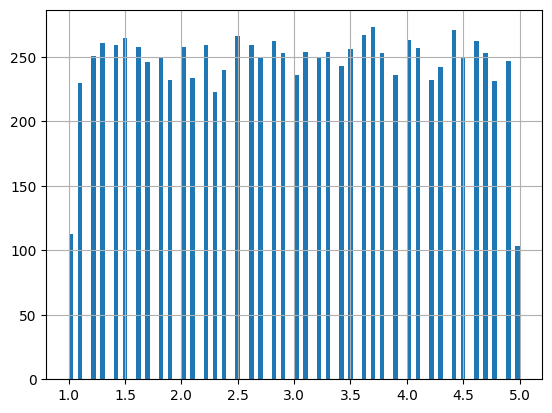

In [ ]:
df_data["Engine_Size"].hist(bins=100)

<Axes: >

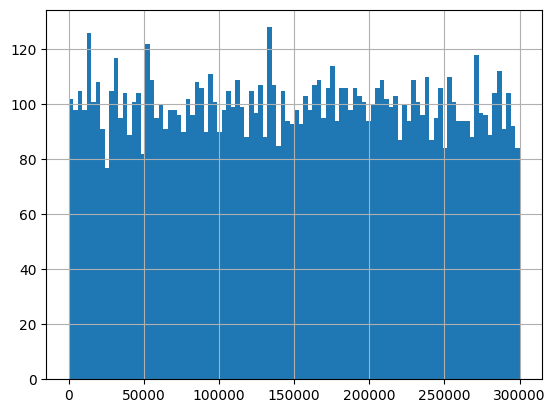

In [ ]:
df_data["Mileage"].hist(bins=100)

<Axes: >

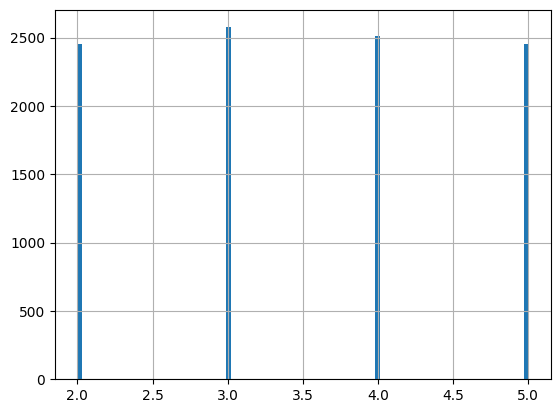

In [ ]:
df_data["Doors"].hist(bins=100)

<Axes: >

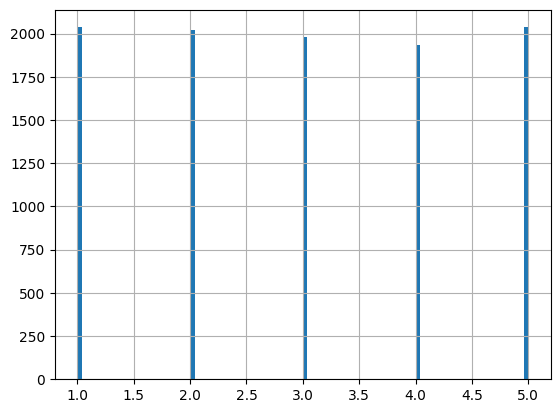

In [ ]:
df_data["Owner_Count"].hist(bins=100)

<Axes: >

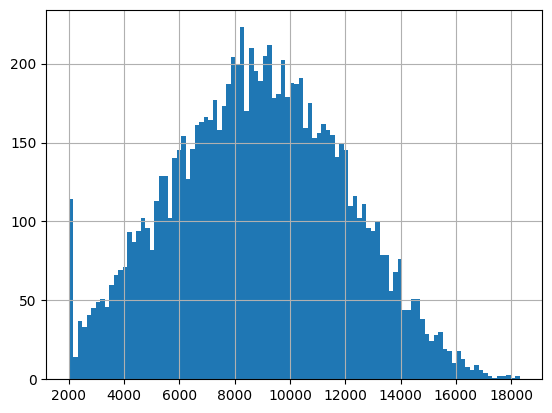

In [ ]:
df_data["Price"].hist(bins=100)

Бинаризируем признак Price. Если цена больше 10000.0 то значение  = 1, если меньше то = 0.

In [ ]:
train["Price"]=(train["Price"] <= 10000.0).astype(int)

test["Price"]=(test["Price"] <= 10000.0).astype(int)

In [ ]:
train

,Brand,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
752,BMW,2022,4.2,Diesel,Automatic,51622,5,2,0
4100,BMW,2004,NaN,Electric,Semi-Automatic,100428,4,2,1
7622,Hyundai,2010,1.9,Diesel,Automatic,259644,3,2,1
1388,Ford,2011,4.0,Hybrid,Automatic,210158,2,2,1
3060,BMW,2013,4.0,Diesel,Automatic,151734,2,3,0
...,...,...,...,...,...,...,...,...,...
5021,Toyota,2001,1.4,Hybrid,Semi-Automatic,109297,2,2,1
9819,Mercedes,2001,3.6,Diesel,Manual,277678,2,4,1
5672,Hyundai,2018,NaN,Diesel,Automatic,43735,3,5,0
6786,Audi,2011,3.7,Hybrid,Manual,260944,5,5,1


In [ ]:
test

,Brand,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
986,BMW,2016,2.2,Diesel,Manual,282955,2,4,1
4061,Hyundai,2003,2.8,Petrol,Manual,68097,4,5,1
8091,BMW,2008,2.1,Petrol,Automatic,266257,5,1,1
9445,Volkswagen,2007,NaN,Electric,Manual,2086,2,2,0
9646,Mercedes,2019,4.0,Diesel,Semi-Automatic,40078,3,5,0
...,...,...,...,...,...,...,...,...,...
4533,BMW,2004,1.2,Petrol,Semi-Automatic,13525,5,5,1
6446,Kia,2004,2.9,Petrol,Automatic,141489,4,5,1
3194,Volkswagen,2001,NaN,Petrol,Automatic,155536,5,3,1
5299,Hyundai,2000,3.6,Electric,Automatic,57404,4,1,0


Приведем типы столбцов датасета к корректным.

In [ ]:
Brand_cat = pd.CategoricalDtype(
    categories=["Kia", "Chevrolet", "BMW", "Ford", "Volkswagen", "Audi", "Honda", "Hyundai", "Toyota", "Mercedes"],
    ordered=False
)

Fuel_Type_cat = pd.CategoricalDtype(
    categories=["Diesel", "Hybrid", "Electric", "Petrol"],
    ordered=False
)

Transmission_cat = pd.CategoricalDtype(
    categories=["Manual", "Automatic", "Semi-Automatic"],
    ordered=False
)

In [ ]:
train = train.astype(
    {#
        "Brand": Brand_cat,
        "Year": np.float64,
        "Engine_Size": np.float64,
        "Fuel_Type": Fuel_Type_cat,
        "Transmission": Transmission_cat,
        "Mileage": np.float64,
        "Doors": np.int64,
        "Owner_Count": np.int64,
        "Price": np.int64
    }

)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 752 to 5530
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Brand         7000 non-null   category
 1   Year          7000 non-null   float64 
 2   Engine_Size   5600 non-null   float64 
 3   Fuel_Type     7000 non-null   category
 4   Transmission  7000 non-null   category
 5   Mileage       7000 non-null   float64 
 6   Doors         7000 non-null   int64   
 7   Owner_Count   7000 non-null   int64   
 8   Price         7000 non-null   int64   
dtypes: category(3), float64(3), int64(3)
memory usage: 662.1 KB


Выполним кодирование категориальных признаков и стандартизацию количественных.

Признак, отвечающий за объем двигателя, пустые значения в котором будем заполнять с помощью байесовской модели, оставим без изменений.

In [ ]:
test = test.astype(
    {#
        "Brand": Brand_cat,
        "Year": np.float64,
        "Engine_Size": np.float64,
        "Fuel_Type": Fuel_Type_cat,
        "Transmission": Transmission_cat,
        "Mileage": np.float64,
        "Doors": np.int64,
        "Owner_Count": np.int64,
        "Price": np.int64
    }

)

test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 986 to 2004
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Brand         3000 non-null   category
 1   Year          3000 non-null   float64 
 2   Engine_Size   2400 non-null   float64 
 3   Fuel_Type     3000 non-null   category
 4   Transmission  3000 non-null   category
 5   Mileage       3000 non-null   float64 
 6   Doors         3000 non-null   int64   
 7   Owner_Count   3000 non-null   int64   
 8   Price         3000 non-null   int64   
dtypes: category(3), float64(3), int64(3)
memory usage: 238.1 KB


In [ ]:
num_features = ["Year", "Mileage", "Doors", "Owner_Count"]
cat_features = ["Brand", "Fuel_Type",
                "Transmission"]

column_transformer = ColumnTransformer([
    ("cat_transformer", OrdinalEncoder(dtype='int'), cat_features),
    ("num_transformer", StandardScaler(), num_features)
], remainder='passthrough', verbose_feature_names_out=False)

In [ ]:
column_transformer.set_output(transform="pandas")
train = column_transformer.fit_transform(train)
train

,Brand,Fuel_Type,Transmission,Year,Mileage,Doors,Owner_Count,Engine_Size,Price
752,1,0,0,1.519992,-1.133401,1.358143,-0.695543,4.2,0
4100,1,1,2,-1.094637,-0.570959,0.458114,-0.695543,NaN,1
7622,5,0,0,-0.223094,1.263853,-0.441914,-0.695543,1.9,1
1388,3,2,0,-0.077837,0.693574,-1.341942,-0.695543,4.0,1
3060,1,0,0,0.212677,0.020294,-1.341942,0.007229,4.0,0
...,...,...,...,...,...,...,...,...,...
5021,8,2,2,-1.530409,-0.468752,-1.341942,-0.695543,1.4,1
9819,7,0,1,-1.530409,1.471677,-1.341942,0.710000,3.6,1
5672,5,0,0,0.938963,-1.224291,-0.441914,1.412772,NaN,0
6786,0,2,1,-0.077837,1.278834,1.358143,1.412772,3.7,1


Разделим датасет и добавим пропущенные значения

In [ ]:
column_transformer.set_output(transform="pandas")
test = column_transformer.fit_transform(test)
test

,Brand,Fuel_Type,Transmission,Year,Mileage,Doors,Owner_Count,Engine_Size,Price
986,1,0,1,0.640627,1.589210,-1.364645,0.707298,2.2,1
4061,5,3,1,-1.235928,-0.932083,0.441237,1.410612,2.8,1
8091,1,3,0,-0.514176,1.393264,1.344178,-1.402641,2.1,1
9445,9,1,1,-0.658526,-1.706703,-1.364645,-0.699328,NaN,0
9646,7,0,2,1.073678,-1.260878,-0.461704,1.410612,4.0,0
...,...,...,...,...,...,...,...,...,...
4533,1,3,2,-1.091577,-1.572469,1.344178,1.410612,1.2,1
6446,6,3,0,-1.091577,-0.070850,0.441237,1.410612,2.9,1
3194,9,3,0,-1.524629,0.093987,1.344178,0.003985,NaN,1
5299,5,1,0,-1.668979,-1.057562,0.441237,-1.402641,3.6,0


In [ ]:
# train, test = train_test_split(df_data, test_size=0.3)


# idx_replace = np.random.choice(train.index, int(0.2 * len(train)), replace=False)
# train.loc[idx_replace, 'Engine_Size'] = np.nan  # Используем loc, потому что индексы совпадают

# idx_replace1 = np.random.choice(test.index, int(0.2 * len(test)), replace=False)
# test.loc[idx_replace1, 'Engine_Size'] = np.nan  # Аналогично для test



Index(['Brand', 'Fuel_Type', 'Transmission', 'Year', 'Mileage', 'Doors',
       'Owner_Count', 'Engine_Size', 'Price'],
      dtype='object')
      Brand  Fuel_Type  Transmission      Year   Mileage     Doors  \
2874      8          2             0 -0.078827  0.864546  1.353914   
1551      0          1             1 -1.383676  0.275190  0.453046   
8608      7          3             2 -0.658760  1.566948 -1.348689   
8552      1          1             0 -1.093709  0.398282 -1.348689   
489       3          1             0 -0.223810  0.825377  0.453046   
...     ...        ...           ...       ...       ...       ...   
2074      6          0             2  0.066156  0.591810 -1.348689   
8891      8          1             1 -1.528659  0.050788  1.353914   
1851      8          0             2  0.646088 -0.694734  0.453046   
8241      4          3             2  1.660970  0.156606 -1.348689   
7823      1          3             2 -0.658760 -1.418025 -0.447821   

      Owner_Count

Создадим функцию, преобразующую данные в датафрейме в тензоры PyTorch

In [ ]:
def convert_df_to_tensors(data: pd.DataFrame) -> dict[str, torch.Tensor]:
    tensors: dict[str, torch.Tensor] = {}
    for column in data.columns:
        tensors[column] = torch.tensor(data[column].values)
    return tensors

Поставим задачу классификации следующим образом: предсказать вероятность что цена авто будет выше 10 тыс. долларов по его характеристикам, представленным в датасете. Одновременно с решением задачи классификации следует заполнить пропуски в столбце "Объем двигателя". Требуется визуализовать априорные и апостериорные распределения коэффициентов байесовской модели, а также распределение целевой переменной для произвольного объекта тестового датасета.

Определим модель в виде следующей функции.

In [ ]:
def model(data: dict[str, torch.Tensor], is_training: bool = False) -> None:
    b_year = pyro.sample("b_year", dist.Normal(0, 1))
    b_Engine_Size = pyro.sample("b_Engine_Size", dist.Normal(0, 1))
    b_Mileage = pyro.sample("b_Mileage", dist.Normal(0, 1))
    b_Doors = pyro.sample("b_Doors", dist.Normal(0, 1))
    b_Owner_Count = pyro.sample("b_Owner_Count", dist.Normal(0, 1))


    logits = b_year * data["Year"]
    logits += b_Mileage * data["Mileage"]
    logits += b_Doors * data["Doors"]
    logits += b_Owner_Count * data["Owner_Count"]

    mu_Engine_Size = pyro.sample("mu_Engine_Size", dist.Normal(0, 1))
    std_Engine_Size = pyro.sample("std_Engine_Size", dist.HalfNormal(1))

    impute_Engine_Size = pyro.sample(
        "impute_Engine_Size", dist.Normal(
            mu_Engine_Size,
            std_Engine_Size
        ).mask(False)
    )

    Engine_Size = data["Engine_Size"]
    Engine_Size = torch.where(torch.isnan(Engine_Size),
                                impute_Engine_Size,
                                Engine_Size)


    logits += b_Engine_Size * Engine_Size

    b_Brand = pyro.sample("b_Brand", dist.Normal(0, 1).expand([10]))
    b_Fuel_Type = pyro.sample("b_Fuel_Type", dist.Normal(0, 1).expand([4]))
    b_Transmission = pyro.sample("b_Transmission",
                                              dist.Normal(0, 1).expand([3]))

    logits += b_Brand[data["Brand"]]
    logits += b_Fuel_Type[data["Fuel_Type"]]
    logits += b_Transmission[data["Transmission"]]

    obs = None if not is_training else data["Price"].float()

    with pyro.plate("N", data["Price"].shape[0]):
        pyro.sample("Engine_Size",
                    dist.Normal(mu_Engine_Size, std_Engine_Size),
                    obs=Engine_Size)
        pyro.sample("Price",
                    dist.Bernoulli(logits=logits),
                    obs=obs)

Разобьем датасет на тестовую и обучающую части. Визуализируем графическую вероятностную модель, соответствующую совместному распределению данных и весов.

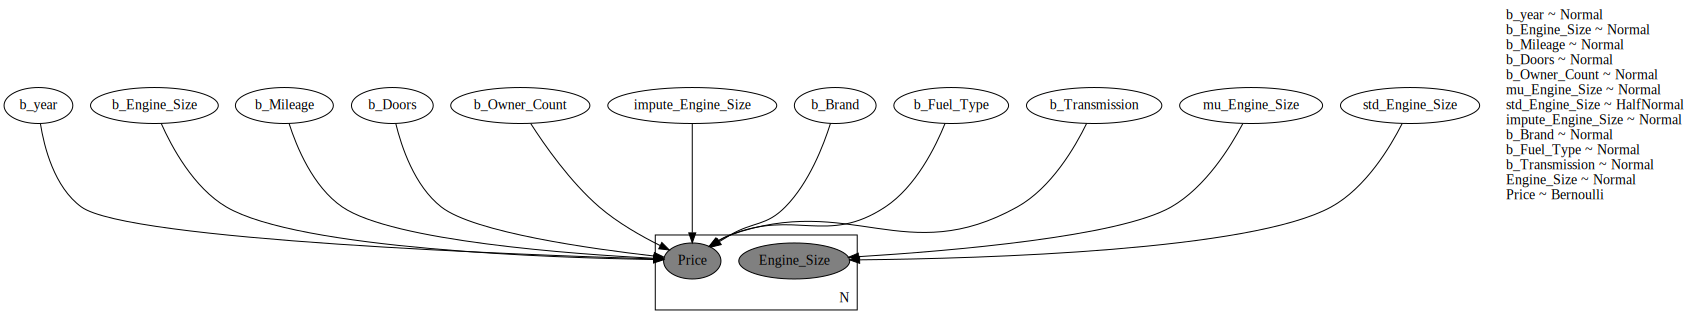

In [ ]:
#train, test = train_test_split(df_data, test_size=0.3)

pyro.render_model(model,
                  model_args=(convert_df_to_tensors(train), True),
                  render_distributions=True,
                  render_params=True)

In [ ]:
trace = pyro.poutine.trace(model).get_trace(
    convert_df_to_tensors(train), True)
print(trace.format_shapes())

          Trace Shapes:       
           Param Sites:       
          Sample Sites:       
            b_year dist      |
                  value      |
     b_Engine_Size dist      |
                  value      |
         b_Mileage dist      |
                  value      |
           b_Doors dist      |
                  value      |
     b_Owner_Count dist      |
                  value      |
    mu_Engine_Size dist      |
                  value      |
   std_Engine_Size dist      |
                  value      |
impute_Engine_Size dist      |
                  value      |
           b_Brand dist   10 |
                  value   10 |
       b_Fuel_Type dist    4 |
                  value    4 |
    b_Transmission dist    3 |
                  value    3 |
                 N dist      |
                  value 7000 |
       Engine_Size dist 7000 |
                  value 7000 |
             Price dist 7000 |
                  value 7000 |


Выполним инференс модели с использованием марковских последовательностей Монте-Карло (MCMC).

Данная процедура выполняет нахождение апостериорного распределения весов модели, многократно сэмплируя из совместного распределения и приводя распределение сэмплов к апостериорному распределению весов.

Процедура сэмплирования может быть достаточно длительной.

In [ ]:
num_of_samples = 600
burn_in_samples = 200

mcmc = MCMC(NUTS(model, jit_compile=True),
            num_samples=num_of_samples, warmup_steps=burn_in_samples)
mcmc.run(convert_df_to_tensors(train), True)
mcmc.summary()

Warmup:   0%|          | 0/800 [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 800/800 [04:30,  2.96it/s, step size=1.44e-01, acc. prob=0.916]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
          b_Brand[0]      1.39      0.35      1.39      0.90      1.98    174.71      1.01
          b_Brand[1]      1.47      0.36      1.46      0.91      2.11    178.34      1.01
          b_Brand[2]      1.55      0.36      1.53      1.01      2.15    167.45      1.01
          b_Brand[3]      1.37      0.35      1.36      0.71      1.86    177.86      1.01
          b_Brand[4]      1.43      0.34      1.42      0.94      2.04    169.28      1.00
          b_Brand[5]      1.69      0.35      1.68      1.12      2.25    172.99      1.01
          b_Brand[6]      1.57      0.35      1.57      1.04      2.19    182.31      1.01
          b_Brand[7]      1.57      0.35      1.55      0.99      2.12    189.30      1.01
          b_Brand[8]      1.39      0.36      1.38      0.71      1.90    178.56      1.00
          b_Brand[9]      1.43      0.35      1.42      0.85      1.99    171.75      1.0

После выполнения процедуры сэмплирования проверьте значения в сводке параметров:

n_eff: должен быть близок к количеству семплов, определяет степень скоррелированности полученных семплов;
r_hat: должен быть близким к единице, что указывает на сходимость метода.
Получить сэмплы из апостериорного распределения весов можно следующим образом:

In [ ]:
posterior_samples = mcmc.get_samples()
posterior_samples

{'b_Brand': tensor([[1.5302, 1.9176, 1.9744,  ..., 2.3894, 1.9473, 2.3475],
         [2.0840, 1.9050, 1.8724,  ..., 1.9602, 2.0702, 2.1480],
         [1.2686, 1.4487, 1.5565,  ..., 1.6683, 1.2663, 1.3047],
         ...,
         [0.9956, 1.2263, 1.1889,  ..., 1.3455, 1.2735, 1.0428],
         [0.7984, 1.3549, 1.4362,  ..., 1.4644, 0.4807, 1.1492],
         [0.8480, 1.0970, 1.1922,  ..., 1.2802, 0.8032, 1.1358]],
        dtype=torch.float64),
 'b_Doors': tensor([-1.5853e-01,  1.3462e-02, -1.6307e-01, -6.4354e-03, -5.9313e-02,
         -1.2083e-01, -1.6518e-01,  2.8868e-02, -1.1594e-01,  5.3595e-03,
         -1.2976e-01, -1.2837e-01, -8.9415e-03, -1.7905e-01, -2.5069e-02,
         -1.4136e-01, -1.4440e-01, -1.7945e-01,  1.2602e-02, -2.6073e-02,
         -1.5774e-02, -1.4296e-01, -6.2162e-02, -6.1556e-02, -1.0048e-01,
         -6.5127e-02, -9.4934e-02, -8.4198e-02, -2.7085e-02, -5.6550e-02,
         -4.5090e-02, -2.1752e-01,  3.7579e-02, -1.8997e-01, -4.1308e-02,
         -2.1868e-02, -1.

Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием апостериорных распределений весов (полученных после обучения модели).

In [ ]:
posterior_predictive = Predictive(model, posterior_samples)(
    convert_df_to_tensors(test))
posterior_predictive

{'Price': tensor([[1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.]], dtype=torch.float64),
 'Engine_Size': tensor([[2.2000, 2.8000, 2.1000,  ..., 3.0359, 3.6000, 4.0000],
         [2.2000, 2.8000, 2.1000,  ..., 3.0369, 3.6000, 4.0000],
         [2.2000, 2.8000, 2.1000,  ..., 3.0223, 3.6000, 4.0000],
         ...,
         [2.2000, 2.8000, 2.1000,  ..., 2.9620, 3.6000, 4.0000],
         [2.2000, 2.8000, 2.1000,  ..., 2.9953, 3.6000, 4.0000],
         [2.2000, 2.8000, 2.1000,  ..., 2.9870, 3.6000, 4.0000]],
        dtype=torch.float64)}

Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием априорных распределений весов (полученных до обучения модели).

In [ ]:
prior = Predictive(model, num_samples=num_of_samples)(
    convert_df_to_tensors(test))
prior

{'b_year': tensor([[ 1.8115e-01],
         [-5.3947e-01],
         [ 1.1867e+00],
         [-7.0274e-01],
         [ 5.8278e-02],
         [ 7.9377e-02],
         [ 5.0364e-01],
         [-1.0263e+00],
         [ 1.4109e+00],
         [ 6.3300e-01],
         [ 1.2387e-01],
         [-3.5839e-01],
         [ 1.0424e+00],
         [-2.1160e-01],
         [ 2.2293e-01],
         [ 3.3251e-02],
         [ 3.8461e-01],
         [ 6.9922e-01],
         [-1.2617e-01],
         [ 2.8729e-02],
         [-4.2715e-01],
         [-7.1758e-01],
         [-2.1748e+00],
         [-2.2287e+00],
         [ 1.6875e-01],
         [ 2.6637e-02],
         [ 1.5144e+00],
         [-7.3320e-01],
         [-1.0559e+00],
         [ 3.9803e-01],
         [ 5.4854e-01],
         [ 8.4878e-01],
         [-2.2076e+00],
         [ 7.6711e-01],
         [-7.8312e-01],
         [ 5.9452e-01],
         [ 7.1554e-01],
         [-8.5186e-01],
         [ 1.1508e+00],
         [ 1.3533e-01],
         [ 8.6747e-01],
      

Сформируем данные для визуализации с помощью библиотеки ArViZ.

In [ ]:
pyro_data = az.from_pyro(
    mcmc, prior=prior, posterior_predictive=posterior_predictive
)
pyro_data

/usr/local/lib/python3.11/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Визуализируем апостериорные распределения всех латентных переменных. "Качество" формы графиков зависит, в том числе, от числа семплов. Увеличение количества семплов приводит к формированию более точных распределений, но и увеличивает расчётное время.

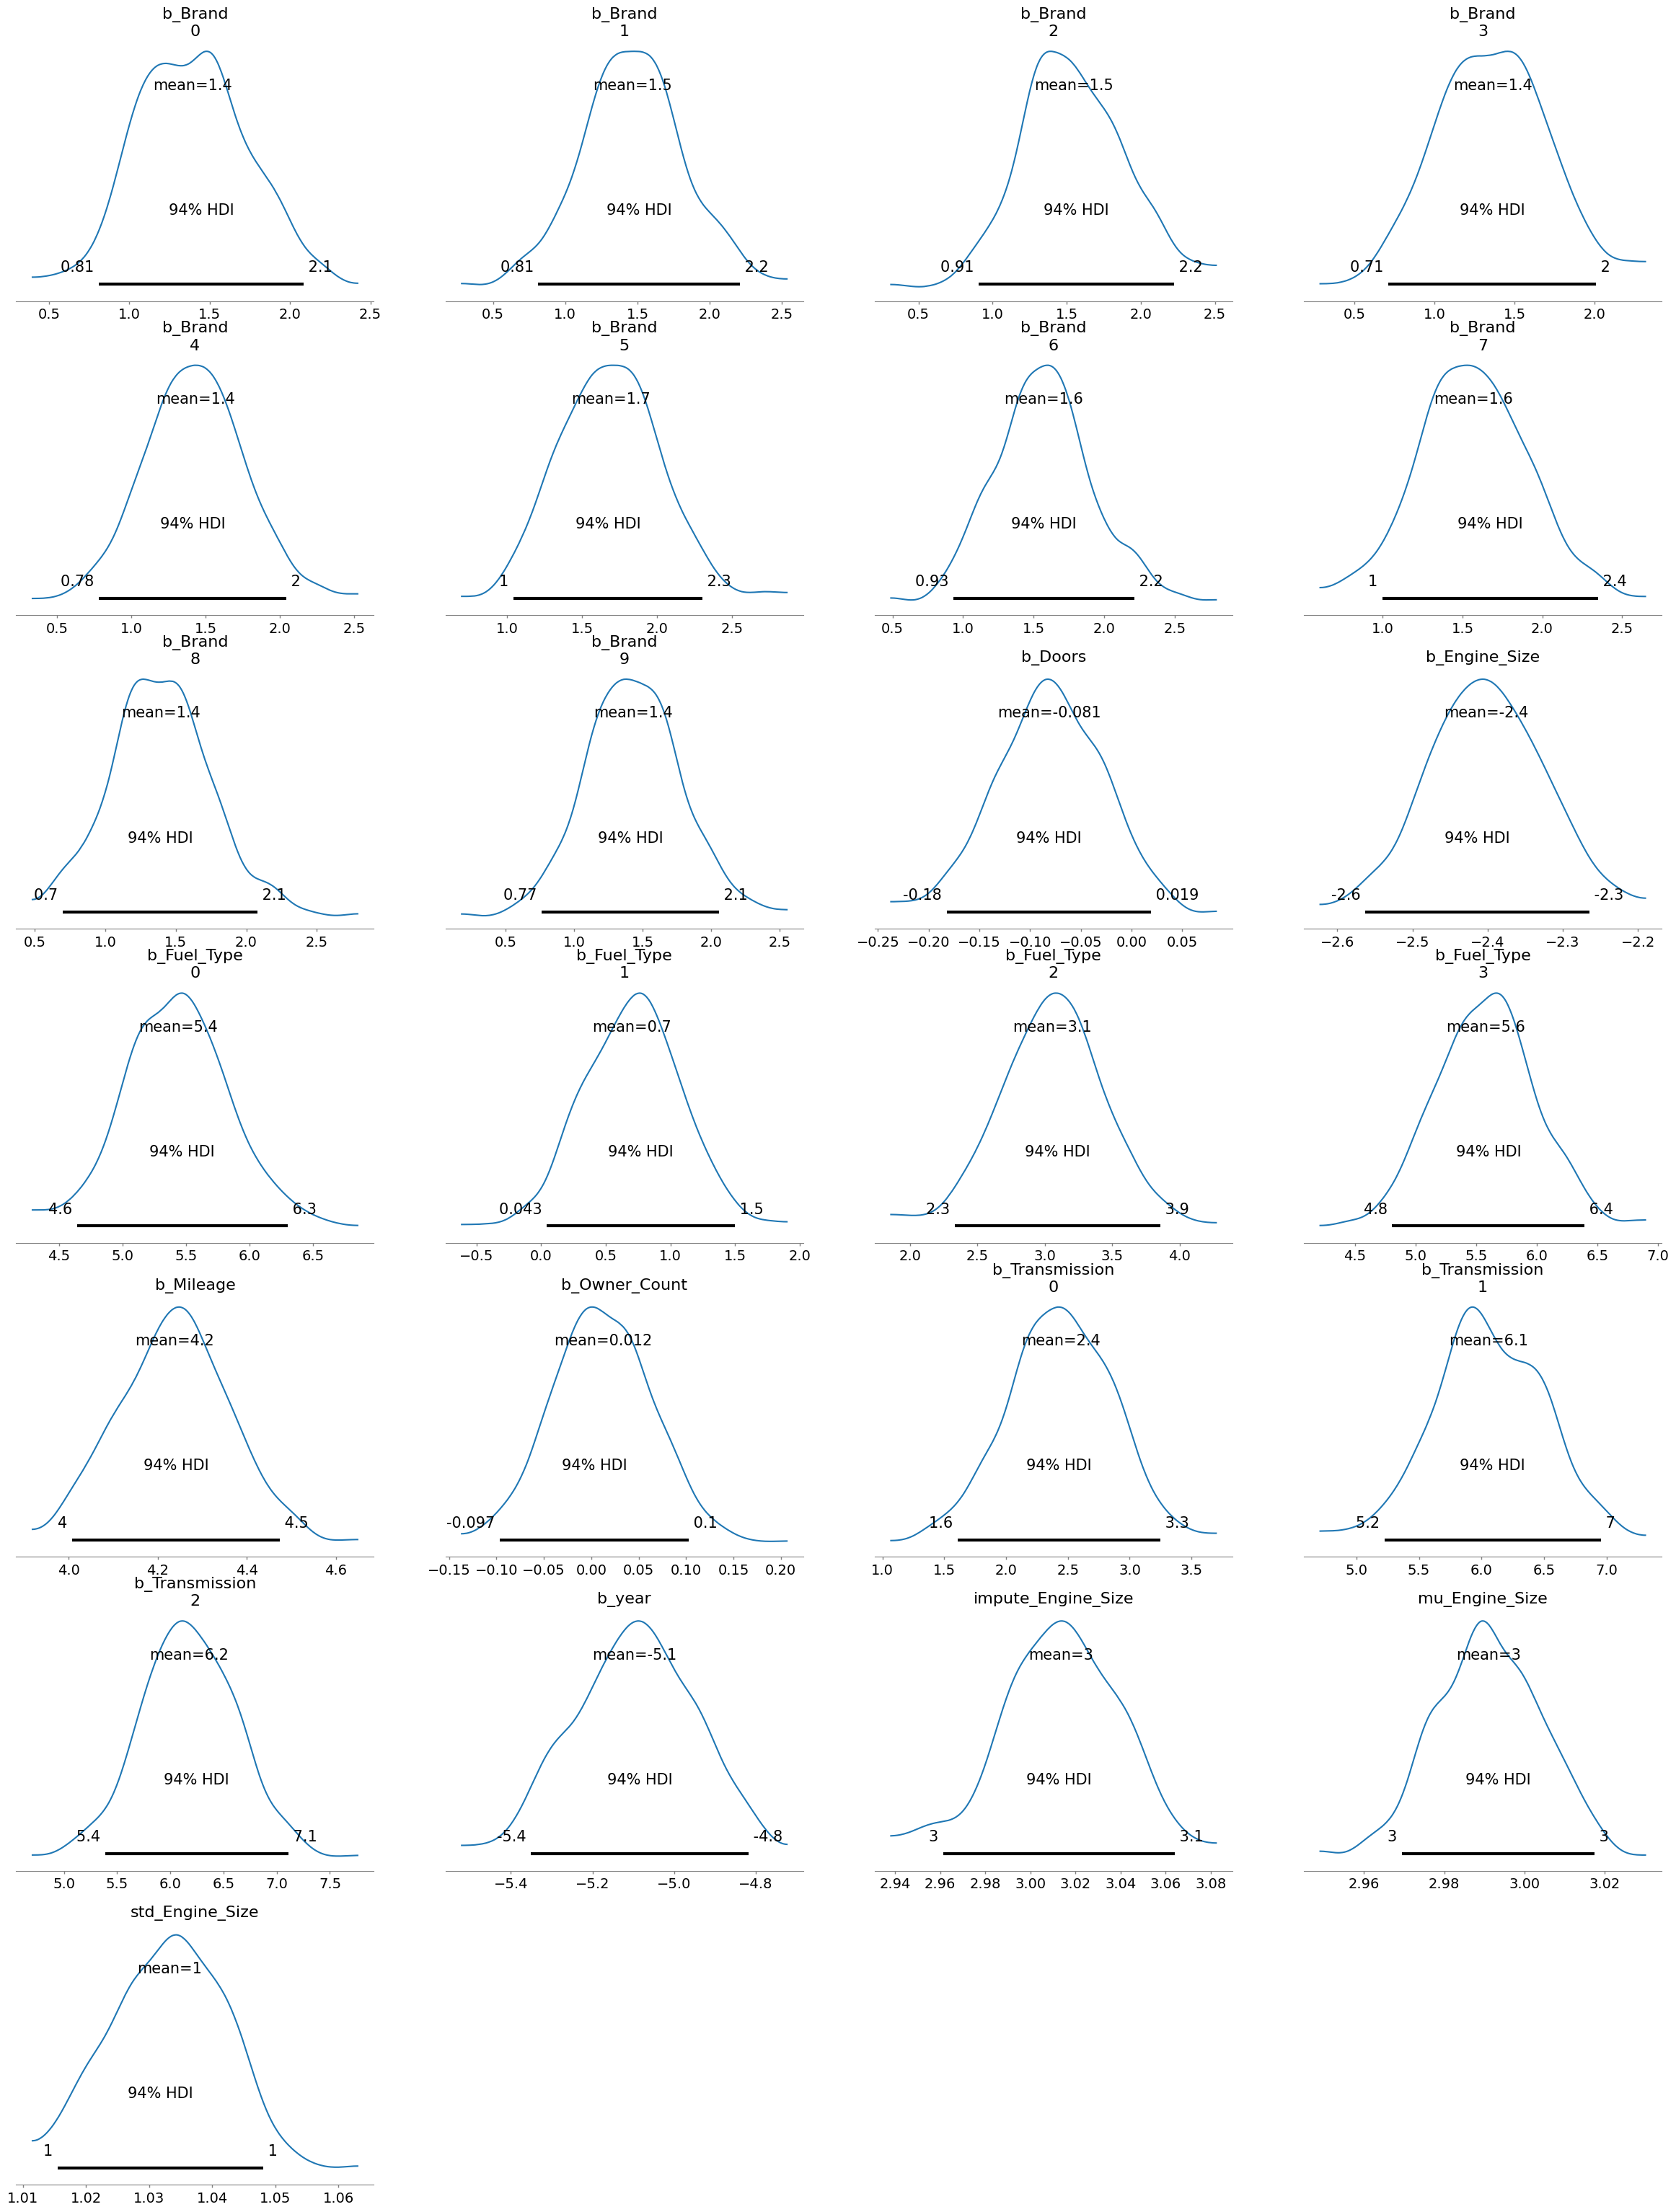

In [ ]:
az.plot_posterior(pyro_data);

Визуализируем априорные и апостериорные распределения для каждой латентной переменной и сравним их.

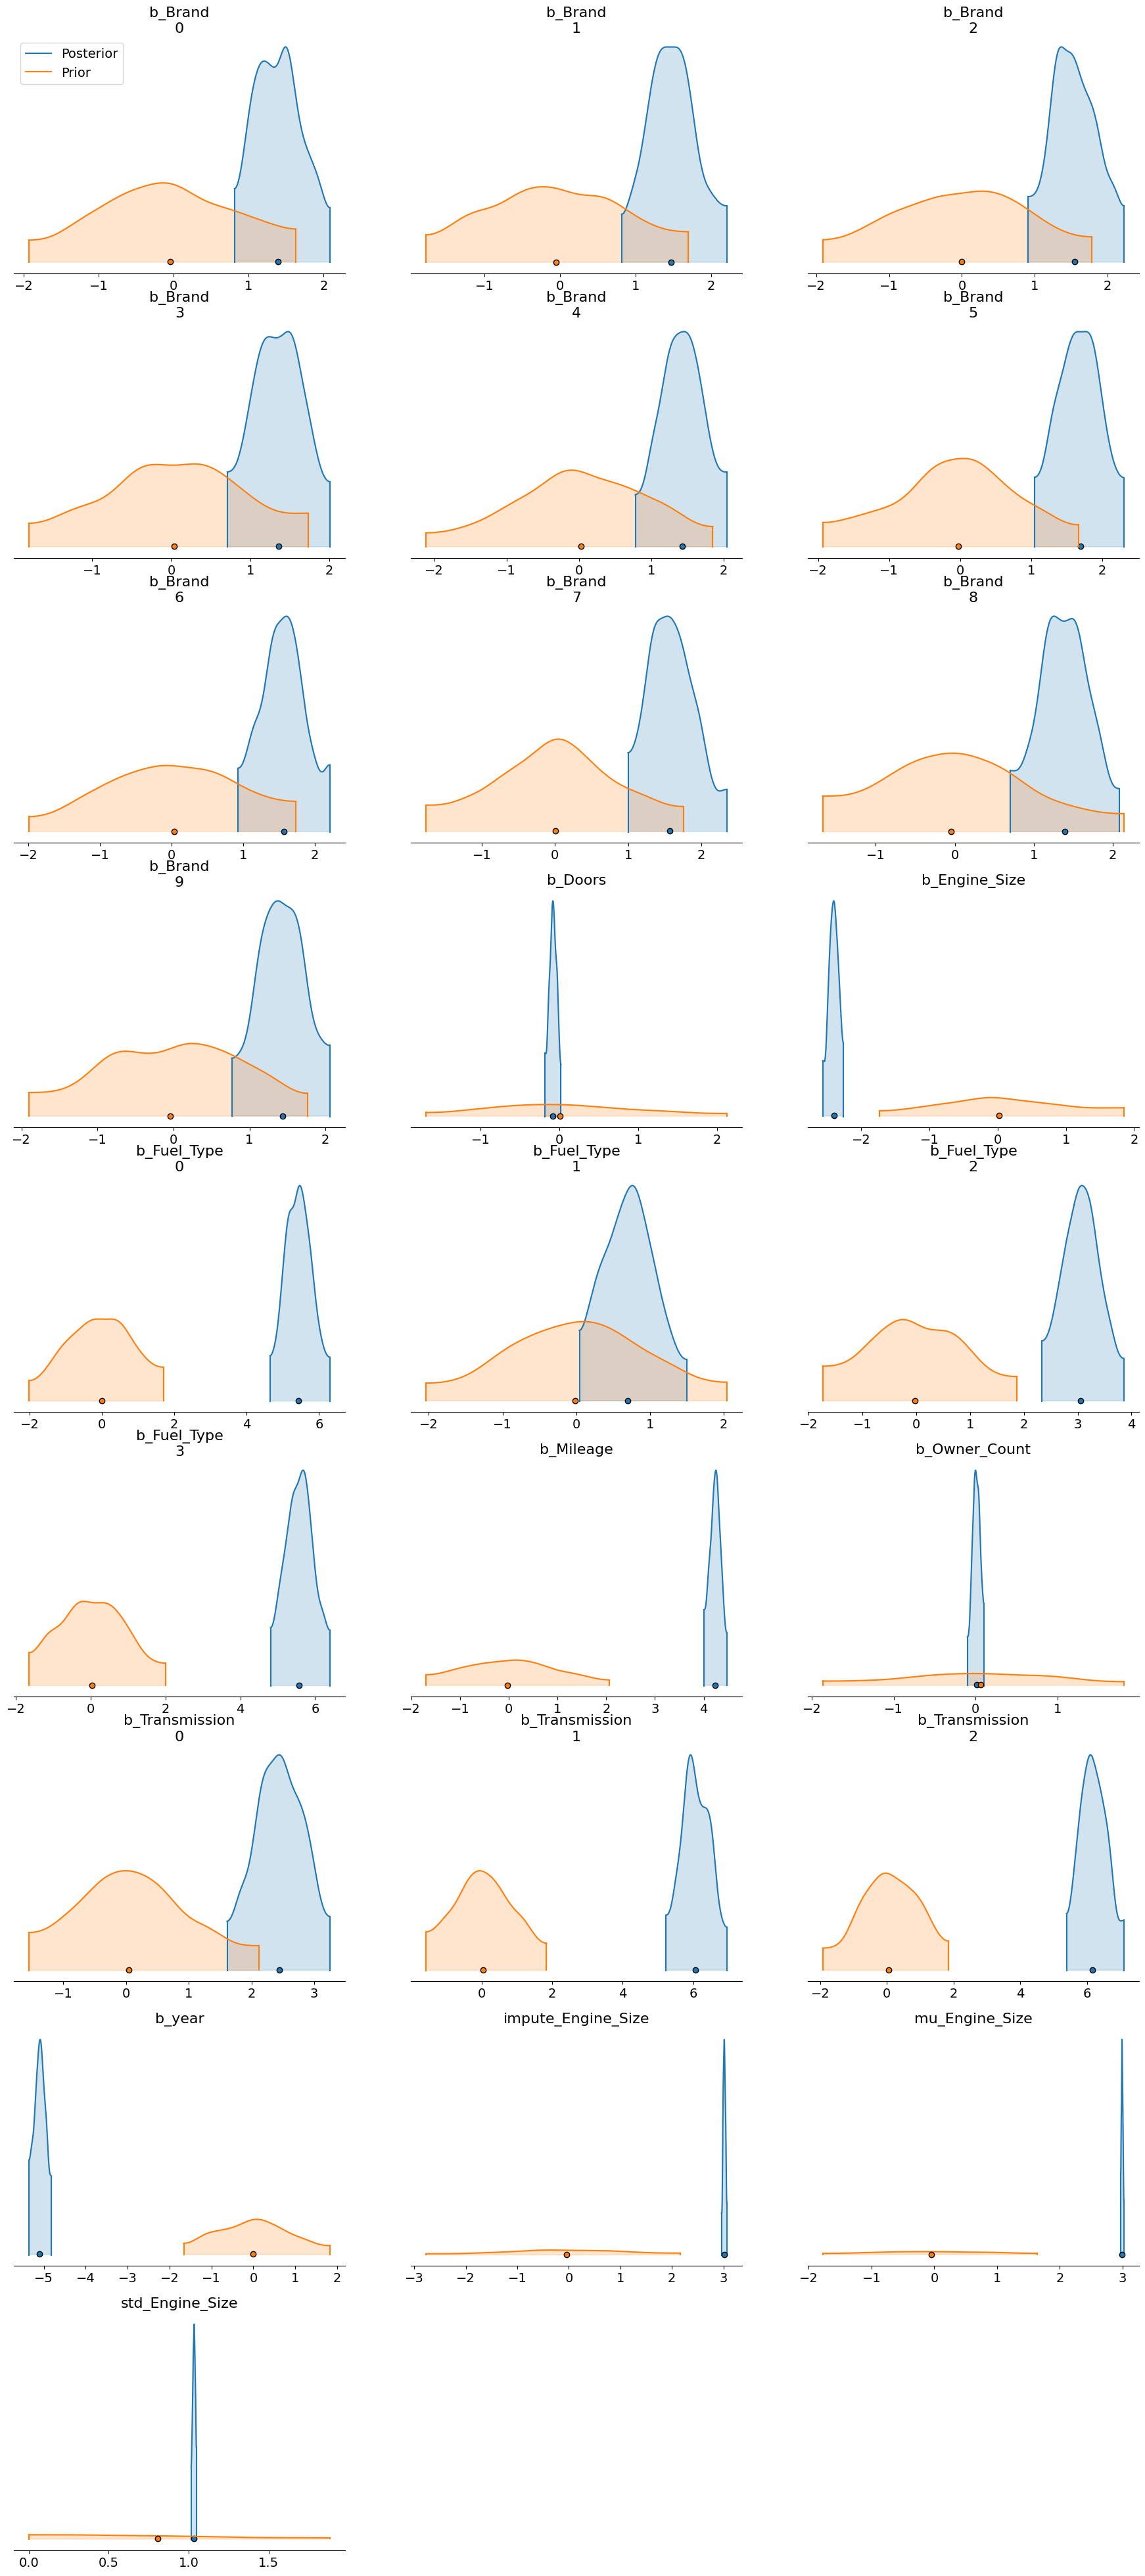

In [ ]:
axes = az.plot_density(
    [pyro_data.posterior, pyro_data.prior],
    data_labels=["Posterior", "Prior"],
    shade=0.2
)

Визуализируем семейство распределений латентных переменных, полученных моделью, и сравним их с эмпирическим распределением, сформированным из тестового датасета.

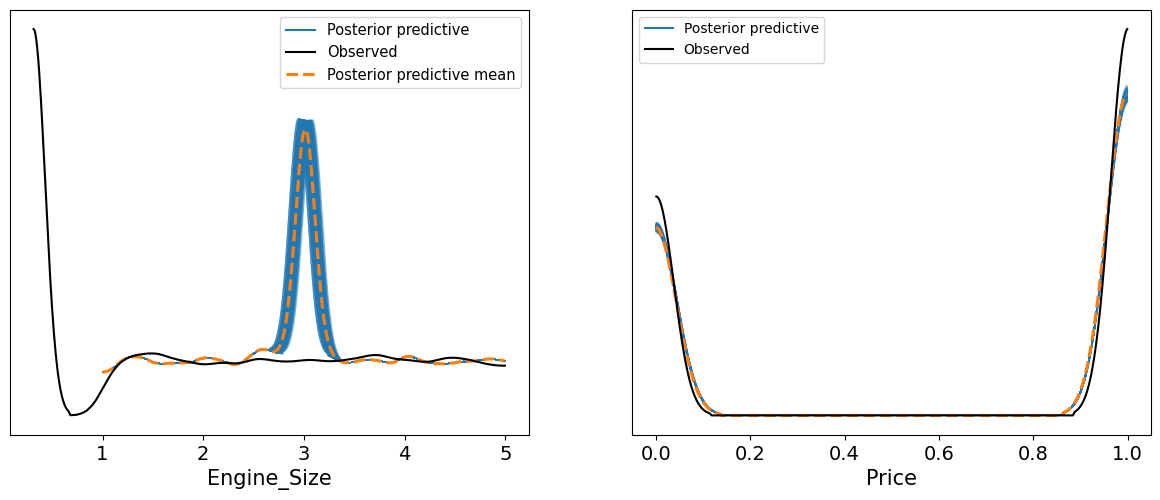

In [ ]:
az.plot_ppc(pyro_data);

Посмотрим на апостериорные распределения латентных переменных (весов модели) всесте с "трассой" -- набором сэмплов, полученных в процессе выполнения инференса методом MCMC.

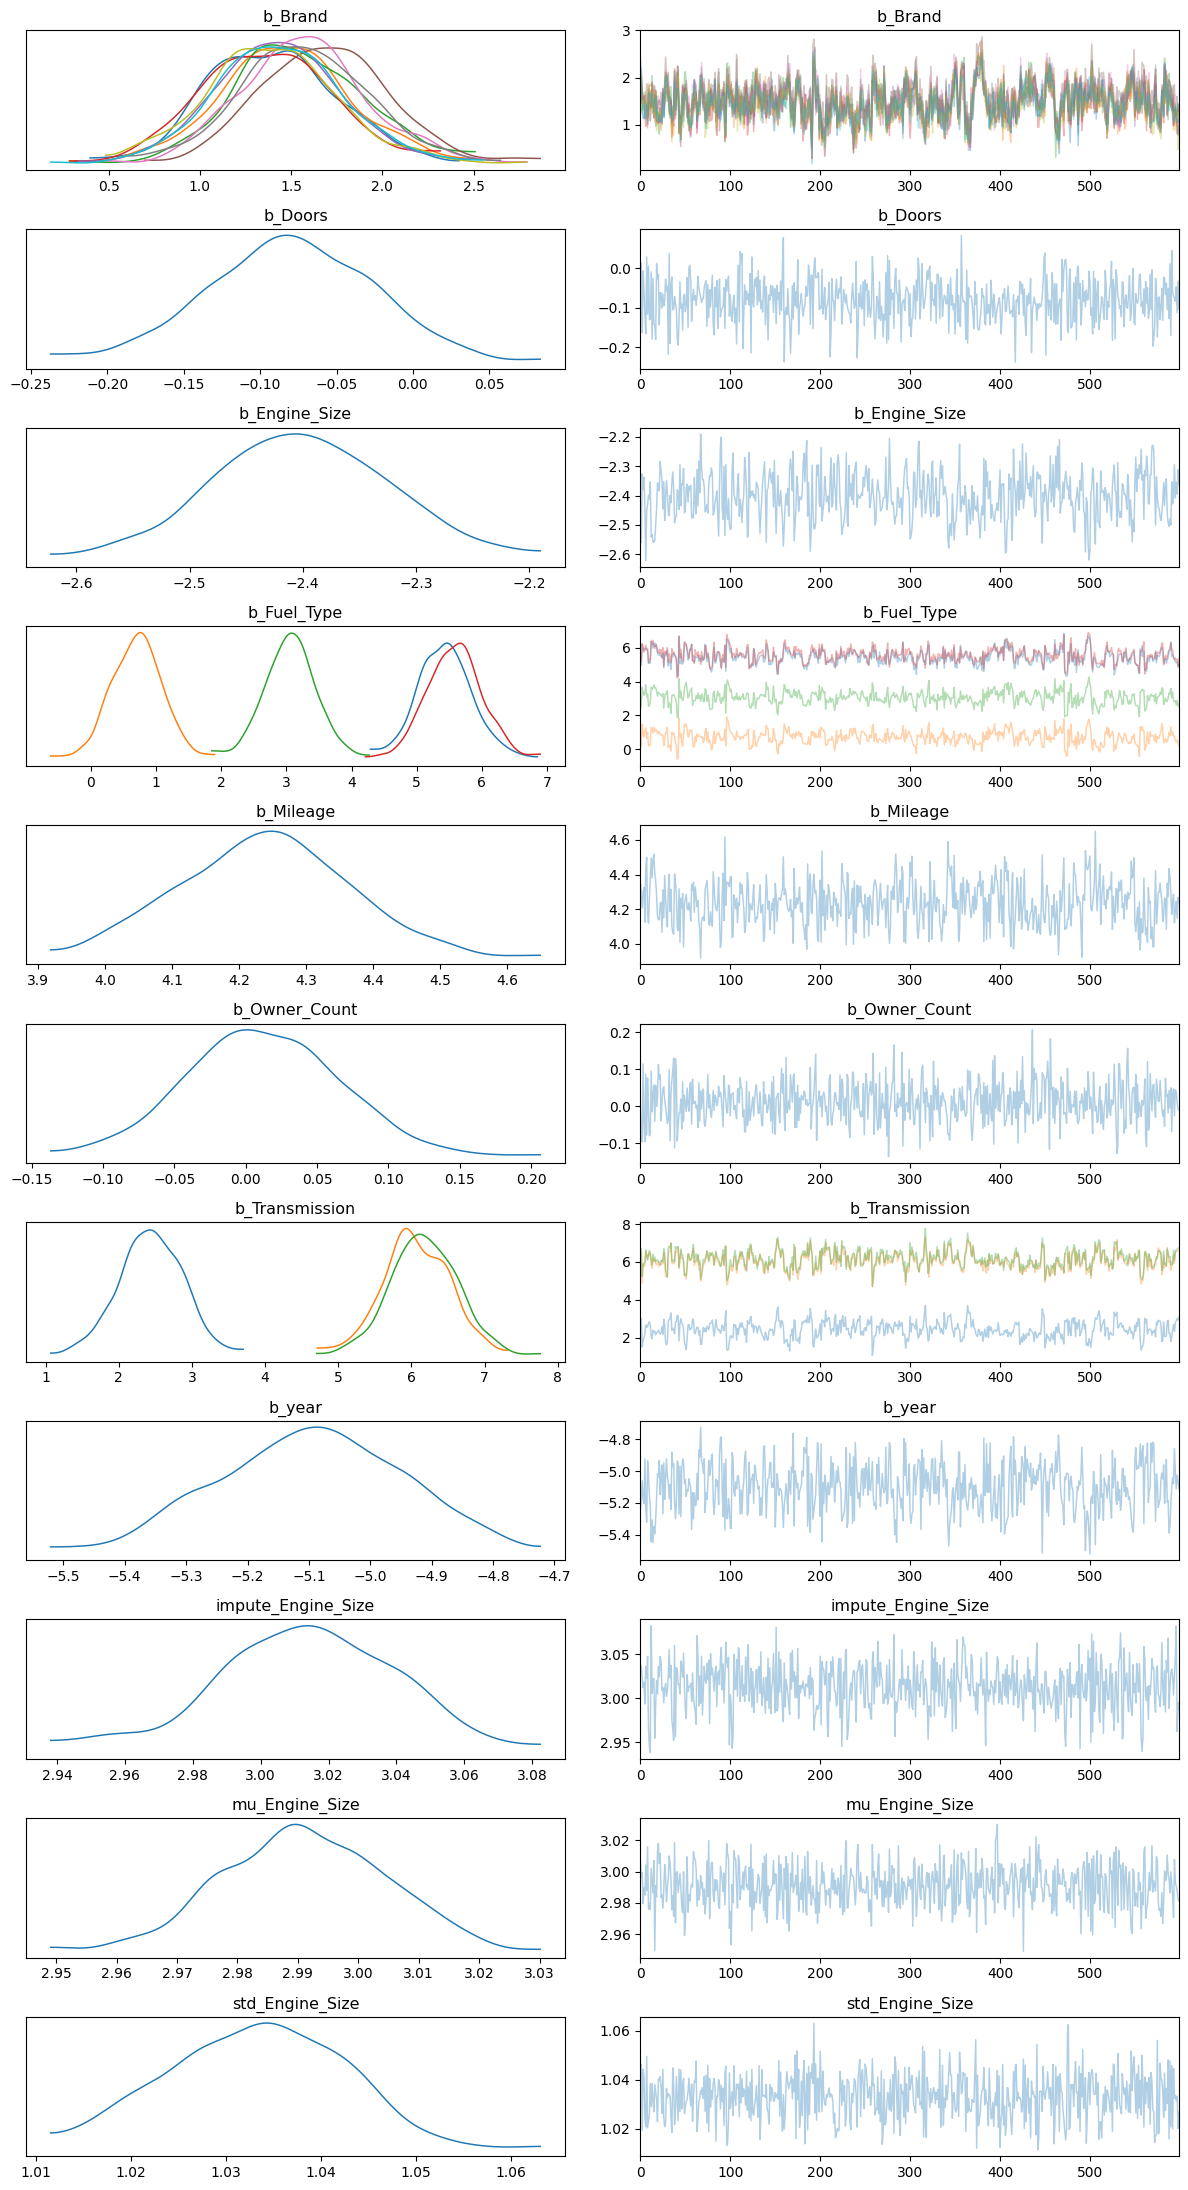

In [ ]:
az.plot_trace(pyro_data)
plt.gcf().tight_layout()

Визуализируем распределение переменной ценны (целевая бинарная переменная, показывающая, возвращен ли клиентом кредит) для одного случайного клиента. Красной пунктирной линией показано истинное значение целевой переменной у данного объекта.

Ground True value:  1
Probability of label to be one:  0.4866666666666667
Distribution:


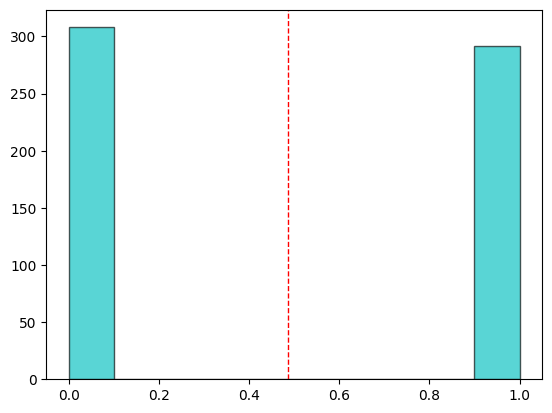

In [ ]:
test_one = test.sample(n=1)

posterior_predictive_one = Predictive(model, posterior_samples)(
    convert_df_to_tensors(test_one))
ser = pd.Series(
    posterior_predictive_one["Price"].detach().numpy().squeeze()
)
print("Ground True value: ", test_one["Price"].values.squeeze())
print("Probability of label to be one: ", ser.mean())
print("Distribution:")
result = plt.hist(ser, color='c', edgecolor='k', alpha=0.65)
plt.axvline(ser.mean(), color='r', linestyle='dashed', linewidth=1)

Сформируем фрагмент датафрейма с результатами предсказаний.

In [ ]:
df_result = test.copy()

In [ ]:
pred_mean = posterior_predictive['Price'].numpy().mean(axis=0)
pred_std  = posterior_predictive['Price'].numpy().std(axis=0)

df_result["Price_pred"] = [
    f"{mean:.2f} ± {std:.2f}" for mean, std in zip(pred_mean, pred_std)
]

loan_mean = posterior_predictive['Engine_Size'].numpy().mean(axis=0)
loan_std  = posterior_predictive['Engine_Size'].numpy().std(axis=0)

df_result["Engine_Size_pred"] = [
    f"{mean:.2f} ± {std:.2f}" for mean, std in zip(loan_mean, loan_std)
]

df_result[["Engine_Size",
           "Engine_Size_pred",
           "Price",
           "Price_pred"]]

,Engine_Size,Engine_Size_pred,Price,Price_pred
986,2.2,2.20 ± 0.00,1,1.00 ± 0.00
4061,2.8,2.80 ± 0.00,1,1.00 ± 0.00
8091,2.1,2.10 ± 0.00,1,1.00 ± 0.00
9445,NaN,3.01 ± 0.03,0,0.05 ± 0.22
9646,4.0,4.00 ± 0.00,0,0.00 ± 0.00
...,...,...,...,...
4533,1.2,1.20 ± 0.00,1,1.00 ± 0.00
6446,2.9,2.90 ± 0.00,1,1.00 ± 0.00
3194,NaN,3.01 ± 0.03,1,1.00 ± 0.00
5299,3.6,3.60 ± 0.00,0,0.53 ± 0.50
